In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


from keras.layers import LSTM


from keras import metrics

from sklearn.preprocessing import MinMaxScaler

import glob, os
import gc
import time

from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, GRU, Input
from keras.layers.normalization import BatchNormalization
from keras import backend as K
from tensorflow import set_random_seed

from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
np.random.seed(7)
set_random_seed(7)

In [ ]:
csv5 = 'history_export_2018-05-08T10_10_05.CSV'
dataset = pd.read_csv(csv5, sep=';', names=[
    'Year',
    'Month',
    'Day',
    'Hour',
    'Minute',
    'Temperature',
    'Humidity',
    'Pressure',
    'Precipitation',
    'Snowfall',
    'Total Cloud Cover',
    'High Cloud Cover',
    'Medium Cloud Cover',
    'Low Cloud Cover',
    'Sunshine Duration',
    'Shortwave Radiation',
    'Wind Speed at 10m',
    'Wind Direction at 10m',
    'Wind Speed at 80m',
    'Wind Direction at 80m',
    'Wind Speed at 900 mb',
    'Wind Direction at 900 mb',
    'Wind Gust'  
])

latitude = dataset.iloc[[0]]
longtitude = dataset.iloc[[1]]
latitude = float(latitude['Temperature'].iloc[0])
longtitude = float(longtitude['Temperature'].iloc[0])


dataset = dataset.drop(dataset.index[[0,1,2,3,4,5,6,8,9,10]])
units = dataset.iloc[[0]]
dataset = dataset.drop(dataset.index[[0]])


In [4]:
# DateTime optimization.
import datetime

from pytz import timezone
import pytz

basel =  timezone('Etc/GMT+2')
dataset.index = pd.to_datetime(dataset[['Year', 'Month', 'Day', 'Hour', 'Minute']])


# Day of year.
dataset['DayOfYear'] = dataset.index.strftime('%j').astype(int)

In [ ]:
# Convert everything to numeric values.
dataset = dataset.convert_objects(convert_numeric=True)

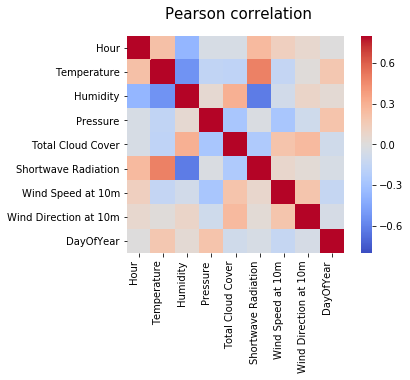

In [6]:
# Pearson Correlation
corrmat = dataset.drop(['Year', 'Minute', 'Month', 'Day','Wind Speed at 80m',
    'Wind Direction at 80m',
    'Wind Speed at 900 mb',
    'Wind Direction at 900 mb',
    'Wind Gust','High Cloud Cover',
    'Medium Cloud Cover',
    'Precipitation',
    'Snowfall',
    'Sunshine Duration',
    'Low Cloud Cover', ], inplace=False, axis=1)
corrmat = corrmat.corr()
# f, ax = plt.subplots(figsize=(7,7))
sns.heatmap(corrmat, vmin=-.8, vmax=.8, square=True, cmap = 'coolwarm')
plt.rcParams["figure.figsize"] = [7,5]
plt.rcParams["font.size"] = "10"
plt.setp(plt.xticks()[1], rotation=90, ha='right')

plt.suptitle('Pearson correlation', fontsize=15)
plt.show()

In [7]:
# Drop columns
dataset = dataset.drop(['Wind Speed at 80m',
    'Wind Direction at 80m',
    'Wind Speed at 900 mb',
    'Wind Direction at 900 mb',
    'Wind Gust','High Cloud Cover',
    'Medium Cloud Cover',
    'Minute',
    'Low Cloud Cover',
    'Sunshine Duration'], inplace=False, axis=1)

In [8]:
dataset.describe()

,Year,Month,Day,Hour,Temperature,Humidity,Pressure,Precipitation,Snowfall,Total Cloud Cover,Shortwave Radiation,Wind Speed at 10m,Wind Direction at 10m,DayOfYear
count,43848.000000,43848.000000,43848.000000,43848.000000,43848.000000,43848.000000,43848.000000,43848.000000,43848.000000,43848.000000,43848.000000,43848.000000,43848.000000,43848.000000
mean,2015.002189,6.520525,15.719759,11.500000,54.256730,69.516717,1017.373520,0.087760,0.002071,51.133527,162.909661,6.825507,202.133940,183.000547
std,1.415389,3.450048,8.803758,6.922265,13.751119,15.261772,8.476408,0.334562,0.036919,45.737392,229.067838,4.962712,94.095164,105.482514
min,2013.000000,1.000000,1.000000,0.000000,15.350000,17.000000,976.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.670000,1.000000
25%,2014.000000,4.000000,8.000000,5.750000,43.480000,59.000000,1012.600000,0.000000,0.000000,1.500000,0.000000,3.360000,118.070000,92.000000
50%,2015.000000,7.000000,16.000000,11.500000,53.640000,71.000000,1017.300000,0.000000,0.000000,45.000000,12.460000,5.520000,219.810000,183.000000
75%,2016.000000,10.000000,23.000000,17.250000,64.060000,81.000000,1022.500000,0.000000,0.000000,100.000000,281.240000,9.050000,277.542500,274.000000
max,2018.000000,12.000000,31.000000,23.000000,98.060000,100.000000,1049.900000,10.300000,2.310000,100.000000,887.330000,49.700000,360.000000,366.000000


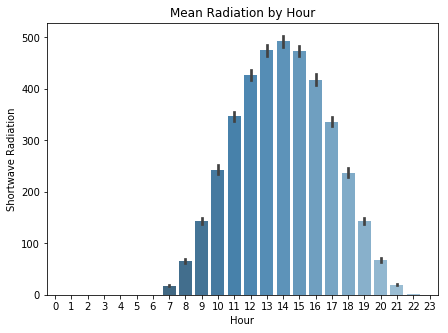

In [9]:
# Mean Radiation by Hour.
ax = plt.axes()
sns.barplot(x="Hour", y='Shortwave Radiation', data=dataset, palette="Blues_d", ax = ax)
ax.set_title('Mean Radiation by Hour')
plt.show()

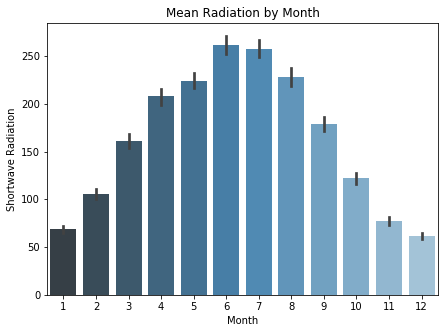

In [10]:
# Mean Radiation by Month.
ax = plt.axes()
sns.barplot(x="Month", y='Shortwave Radiation', data=dataset, palette="Blues_d", ax = ax)
ax.set_title('Mean Radiation by Month')
plt.show()

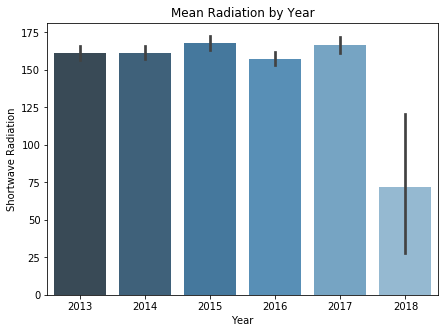

In [11]:
# Mean Radiation by Year.
ax = plt.axes()
sns.barplot(x="Year", y='Shortwave Radiation', data=dataset, palette="Blues_d", ax = ax)
ax.set_title('Mean Radiation by Year')
plt.show()

In [12]:
X = dataset[['Temperature', 'Pressure', 'Humidity', 'Wind Direction at 10m', 'Wind Speed at 10m', 
             'DayOfYear', 'Month', 'Hour', 'Total Cloud Cover']].values
y = dataset['Shortwave Radiation'].values

# Normalization

In [13]:
scalerX = MinMaxScaler()
np_scaledX = scalerX.fit_transform(X)
normalizedX = pd.DataFrame(data=np_scaledX, columns=['Temperature', 'Pressure', 'Humidity', 'Wind Direction at 10m', 'Wind Speed at 10m', 
             'DayOfYear', 'Month', 'Hour', 'Total Cloud Cover']) 

scalerY = MinMaxScaler()
y = y.reshape(-1, 1)
np_scaledY = scalerY.fit_transform(y)
normalizedY = pd.DataFrame(data=np_scaledY, columns=['Shortwave Radiation'])

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)

In [15]:
from sklearn.metrics import r2_score
def r2(model, X_test):
    predictions = model.predict(X_test)
    return r2_score(y_test, predictions)  

In [16]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(normalizedX, normalizedY, test_size = 0.2, shuffle = True)

In [ ]:
# Multilayer Neural Network.
start_time = time.time()


input_shape = X_train.shape[1]

model = Sequential()
model.add(Dense(100, input_shape=(input_shape,), init='glorot_normal', activation='tanh'))
model.add(Dense(50, init='glorot_normal', activation='tanh'))
model.add(Dense(10, init='glorot_normal', activation='tanh'))
model.add(Dense(1, init='glorot_normal', activation='sigmoid'))

In [21]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               1000      
_________________________________________________________________
dense_6 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_7 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 6,571
Trainable params: 6,571
Non-trainable params: 0
_________________________________________________________________


Train on 31570 samples, validate on 3508 samples
Epoch 1/100
31570/31570 [==============================] - 2s 75us/step - loss: 0.0342 - mean_absolute_error: 0.1417 - acc: 0.4618 - val_loss: 0.0160 - val_mean_absolute_error: 0.0998 - val_acc: 0.4666
Epoch 2/100
31570/31570 [==============================] - 2s 59us/step - loss: 0.0093 - mean_absolute_error: 0.0689 - acc: 0.4644 - val_loss: 0.0073 - val_mean_absolute_error: 0.0571 - val_acc: 0.4669
Epoch 3/100
31570/31570 [==============================] - 2s 54us/step - loss: 0.0068 - mean_absolute_error: 0.0544 - acc: 0.4644 - val_loss: 0.0064 - val_mean_absolute_error: 0.0523 - val_acc: 0.4669
Epoch 4/100
31570/31570 [==============================] - 2s 54us/step - loss: 0.0060 - mean_absolute_error: 0.0507 - acc: 0.4644 - val_loss: 0.0054 - val_mean_absolute_error: 0.0474 - val_acc: 0.4669
Epoch 5/100
31570/31570 [==============================] - 2s 55us/step - loss: 0.0053 - mean_absolute_error: 0.0468 - acc: 0.4644 - val_loss: 

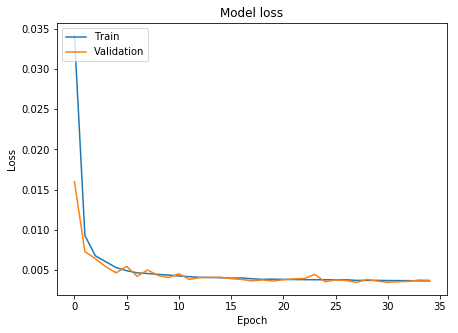

In [22]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001)

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'acc'])
history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_split=0.1, callbacks=[es])
train_time_nn = (time.time() - start_time)
acc_nn = r2(model,X_test)
print("R^2= "+ str(acc_nn))
print("Time= "+ str(train_time_nn))

evaluation = model.evaluate(x = X_test, y = y_test, verbose=1) # Returns MSE, MAE, ACC
mse = evaluation[0]
mae = evaluation[1]
acc = evaluation[2]
print('MSE='+str(mse))
print('MAE='+str(mae))
print('ACC='+str(acc))

# Plot training & validation loss values
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

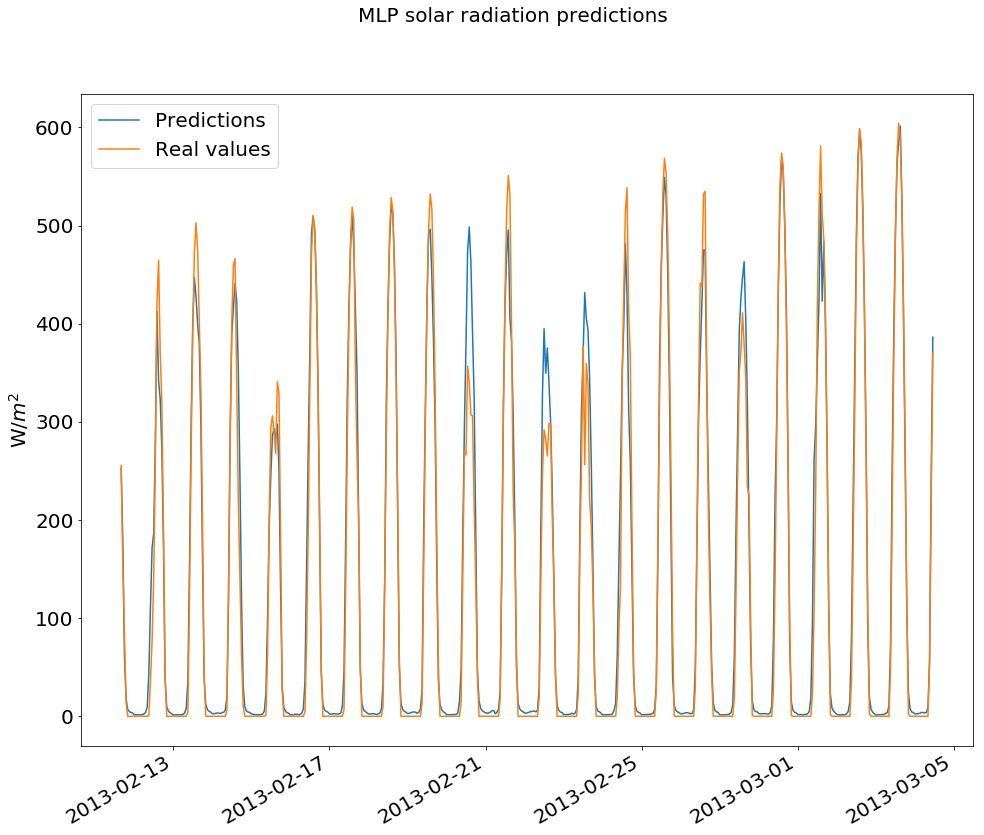

In [24]:
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

prediction = scalerY.inverse_transform(model.predict(normalizedX[1000:1500]))
real = y[1000:1500]
plt.rcParams["figure.figsize"] = [16,12]
plt.rcParams["font.size"] = "20"
plt.ylabel(r'W/$m^2$')
plt.suptitle('MLP solar radiation predictions', fontsize=20)
plt.plot(pd.to_datetime(dataset.index[1000:1500]),prediction, label='Predictions')
plt.plot(pd.to_datetime(dataset.index[1000:1500]),real, label='Real values')
plt.legend(loc='upper left')

plt.setp(plt.xticks()[1], rotation=30, ha='right')

plt.show()

In [25]:
evaluation = model.evaluate(x = X_test, y = y_test, verbose=1) # Returns MSE, MAE, ACC
mse = evaluation[0]
mae = evaluation[1]
acc = evaluation[2]
print('MSE='+str(mse))
print('MAE='+str(mae))
print('ACC='+str(acc))

8770/8770 [==============================] - 0s 16us/step
MSE=0.003674766250000364
MAE=0.03265341259921426
ACC=0.47240592930444697


In [26]:
mse_mlp = mean_squared_error(scalerY.inverse_transform(y_test), scalerY.inverse_transform(model.predict(X_test)))
mae_mlp = mean_absolute_error(scalerY.inverse_transform(y_test), scalerY.inverse_transform(model.predict(X_test)))

In [27]:
mse_mlp

2893.3438293589093

In [28]:
mae_mlp

28.974352336096246